In [1]:
import csv
import cv2
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
lines = []
with open('driving_data/combined_data.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
print("--- CSV data loaded. ---")

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("Train Samples: {} \nValidation Samples: {}".format(len(train_samples), len(validation_samples)))

--- CSV data loaded. ---
Train Samples: 12914 
Validation Samples: 3229


In [3]:
def preprocess_image(img):
    # NORMALIZE IMAGE
#     img = img / 255 - 0.5
    # CROP IMAGE
#     crop = img[50:140,:,:]
    # Resize to 64x64 ?
    # image_array = cv2.resize(image_array, (64, 64))
    return img

In [4]:
# def augment_data(images, measurements):
#     augmented_images, augmented_measurements = [], []
#     print("Augmenting dataset...")
    
#     for image, measurement in zip(images, measurements):
#         try:
#             augmented_images.append(cv2.flip(image,1))
#             augmented_measurements.append(measurement * -1.0)
#             augmented_images.append(image)
#             augmented_measurements.append(measurement)
#         except:
#             print("image None error occurred.")
            
#     try:    
#         print("Dataset Augmented!")
#         print("type(augmented_images): {}".format(type(augmented_images)))
#         print("type(augmented_images[0]: {}".format(type(augmented_images[0])))
#     except:
#         pass
#     return augmented_images, augmented_measurements

In [5]:
def brighten(img):
    try:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        rand = 0.25 + np.random.uniform()
        img[:,:,2] = img[:,:,2]*rand
        img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    except:
        pass
    return img

In [6]:
def flip(img, angle):
    img = (cv2.flip(img,1))
    angle = angle * -1.0
    return img, angle

In [7]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            # catch error if img is loaded as None
            # Keep old images. if new image failed to load load old image / angle so that generator exports 
                # 192 images per batch set
            images = []
            angles = []
            flipped_img = []
            flipped_angle = []
            steering_angles = []
            prev_imgs = []
            prev_angles = []
            for batch_sample in batch_samples:
                correction = 0.24 # this is a parameter to tune
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                steering_angles.extend((center_angle, left_angle, right_angle)) 
#                 print(steering_angles)
                
                for i in range(3):
                    name = '/home/carnd/P3-Behavioral-Cloning/driving_data/IMG/'+batch_sample[i].split('/')[-1]
                    Image = cv2.imread(name)
                    Image = brighten(Image)  # Randomly brighten image
                    Image = preprocess_image(Image) # crop and normalize
                    flipped_img, flipped_angle = flip(Image, steering_angles[i])

                    
                    # convert to gray?
                    # possibly leave out some near zero steering angle data
                    if i == 0:
                        img_center = np.asarray(Image)
                        center_flip = np.asarray(flipped_img)
                        c_flip_angle = flipped_angle
                    elif i == 1:
                        img_left = np.asarray(Image)
                        left_flip = np.asarray(flipped_img)
                        l_flip_angle = flipped_angle
                    else:
                        img_right = np.asarray(Image)  
                        right_flip = np.asarray(flipped_img)
                        r_flip_angle = flipped_angle

                try: 
                    noneTest = cv2.flip(img_center,1)
                    noneTest = cv2.flip(img_left,1)
                    noneTest = cv2.flip(img_right,1)
                    images.extend((img_center, img_left, img_right, center_flip, left_flip, right_flip))
                    angles.extend((center_angle, left_angle, right_angle, c_flip_angle, l_flip_angle, r_flip_angle))
                    for i in range(-6, 0):
                        prev_imgs.append(images[i])
                        prev_angles.append(angles[i])
                    
                except:
                    print("Exception importing data in generator fcn. Loading from last successfully loaded img")
                    for i in range(0,6):
                        images.append(prev_imgs[i])
                        angles.append(prev_angles[i])
                    print("center, left, right: \n{}\n{}\n{}".format(img_center.shape, img_left.shape, img_right.shape))
                steering_angles = []

            X_train = np.array(images)
            y_train = np.array(angles)
#             print("Completed Batch")
#             print("Array shapes: \nFeatures: {}\nLabels: {}".format(X_train.shape, y_train.shape))
            yield sklearn.utils.shuffle(X_train, y_train)

In [8]:
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

ch, row, col = 3, 90, 320  # Trimmed image format

Using TensorFlow backend.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2

Epoch 1/5
191/192 [============================>.] - ETA: 0s - loss: 0.0787Exception importing data in generator fcn. Loading from last successfully loaded img
center, left, right: 
()
(160, 320, 3)
(160, 320, 3)
Exception importing data in generator fcn. Loading from last successfully loaded img
center, left, right: 
()
(160, 320, 3)
(160, 320, 3)
192/192 [==============================] - 134s - loss: 0.0787 - val_loss: 0.0656
Epoch 2/5
191/192 [============================>.] - ETA: 0s - loss: 0.0675Exception importing data in generator fcn. Loading from last successfully loaded img
center, left, right: 
()
(160, 320, 3)
(160, 320, 3)
192/192 [==============================] - 128s - loss: 0.0674 - val_loss: 0.0629
Epoch 3/5
191/192 [============================>.] - ETA: 0s - loss: 0.0664Exception importing data in generator fcn. Loading from last successfully loaded img
center, left, right: 
()
(160, 320, 3)
(160, 320, 3)
Exception importing data in generator fcn. Loading from las

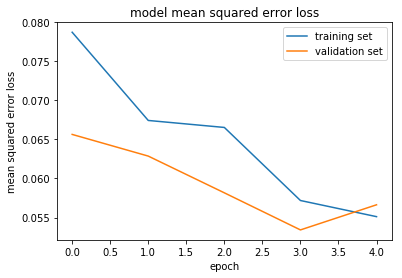

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,30), (0,0))))

# LeNet Architecture
# model.add(Convolution2D(6,5,5,input_shape=(90,320,3), activation="relu"), )
# model.add(MaxPooling2D())
# model.add(Convolution2D(6,5,5,activation="relu"))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(120))
# model.add(Dense(84))
# model.add(Dense(1))

# NVIDIA ARCHITECTURE
model.add(Convolution2D(24,5,5, subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
# model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
history_object = model.fit_generator(train_generator, samples_per_epoch=192, validation_data=validation_generator, nb_val_samples=192, nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')
# import gc
# gc.collect()